## FIT_TRANSFORM TRAINING SET

X_test will transform during the pipeline shown from Week 4, Day 5 pair programming solution
    - DONT HAVE TO DO IT MANUALLY

In [1]:
import csv
import pickle
import pandas as pd
import numpy as np
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import learning_curve, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.style as style
style.use('fivethirtyeight')
%matplotlib inline

from __future__ import print_function, division

# Get pandas and postgres to work together
import psycopg2 as pg
import pandas.io.sql as pd_sql
plt.rc('font', size=18) 

/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
with open('airline_crash.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [3]:
state_df = pd.concat([df['Event_Id'], df['Location'].str.split(', ', expand=True)], axis=1)

In [4]:
state_df['City'] = state_df[0]
state_df['State'] = state_df[1]

state_df = state_df.drop([0,1,2,3,4],1)

In [5]:
df.reset_index(inplace=True)
state_df.reset_index(inplace=True)

In [6]:
df = pd.merge(df, state_df, on='index')

df = df.drop(['Location'],1)

In [7]:
df.Latitude = df.Latitude.astype('float')
df.Longitude = df.Longitude.astype('float')
df.Total_Fatal_Injuries = df.Total_Fatal_Injuries.astype('float')
df.Total_Serious_Injuries = df.Total_Serious_Injuries.astype('float')
df.Total_Minor_Injuries = df.Total_Minor_Injuries.astype('float')
df.Total_Uninjured = df.Total_Uninjured.astype('float')
df.Number_Engines = df.Number_Engines.astype('float')

df['Event_Date'] = pd.to_datetime(df['Event_Date'])

In [8]:
df.head()

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
0,0,20180719X01751,Accident,CEN18LA281,2018-07-19,United States,32.540277,-93.745000,DTN,Shreveport Executive,...,NaN,NaN,1.0,VMC,MANEUVERING,Preliminary,07/23/2018,20180719X01751,Shreveport,LA
1,1,20180717X23051,Accident,GAA18CA428,2018-07-17,United States,36.124445,-86.678056,BNA,Nashville Intl,...,NaN,NaN,NaN,VMC,NaN,Preliminary,07/19/2018,20180717X23051,Nashville,TN
2,2,20180717X82154,Accident,CEN18LA276,2018-07-17,United States,29.868056,-95.795000,IWS,West Houston,...,NaN,NaN,1.0,VMC,NaN,Preliminary,07/19/2018,20180717X82154,Katy,TX
3,3,20180716X44947,Accident,GAA18CA427,2018-07-16,United States,26.002222,-80.240000,HWO,NORTH PERRY,...,NaN,1.0,NaN,VMC,NaN,Preliminary,07/23/2018,20180716X44947,Hollywood,FL
4,4,20180716X60511,Accident,GAA18CA424,2018-07-16,United States,39.564722,-85.235555,N/A,NaN,...,NaN,1.0,NaN,NaN,NaN,Preliminary,07/19/2018,20180716X60511,New Castle,IN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81899 entries, 0 to 81898
Data columns (total 34 columns):
index                     81899 non-null int64
Event_Id_x                81899 non-null object
Investigation_Type        81899 non-null object
Accident_Number           81899 non-null object
Event_Date                81899 non-null datetime64[ns]
Country                   81392 non-null object
Latitude                  28059 non-null float64
Longitude                 28050 non-null float64
Airport_Code              46449 non-null object
Airport_Name              51554 non-null object
Injury_Severity           81899 non-null object
Aircraft_Damage           79321 non-null object
Aircraft_Category         25157 non-null object
Registration_Number       78414 non-null object
Make                      81828 non-null object
Model                     81800 non-null object
Amateur_Built             81267 non-null object
Number_Engines            77419 non-null float64
Engine_Type      

In [10]:
df = df.rename(columns={'Event_Id_x': 'Event_Id'})

In [11]:
df = df.drop(['Event_Id_y'], axis=1)

In [12]:
real_df = df.dropna(subset=['Investigation_Type','Event_Date',
              'Country', 'Injury_Severity',
              'Aircraft_Damage', 'Amateur_Built', 'Number_Engines', 'Engine_Type',
              'Flight_Purpose', 'Total_Fatal_Injuries', 'Total_Serious_Injuries',
              'Total_Minor_Injuries', 'Total_Uninjured', 'Weather_Condition', 'Broad_Phase_of_Flight','City','State'])

real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46435 entries, 16185 to 81898
Data columns (total 33 columns):
index                     46435 non-null int64
Event_Id                  46435 non-null object
Investigation_Type        46435 non-null object
Accident_Number           46435 non-null object
Event_Date                46435 non-null datetime64[ns]
Country                   46435 non-null object
Latitude                  286 non-null float64
Longitude                 286 non-null float64
Airport_Code              25399 non-null object
Airport_Name              27570 non-null object
Injury_Severity           46435 non-null object
Aircraft_Damage           46435 non-null object
Aircraft_Category         3694 non-null object
Registration_Number       46435 non-null object
Make                      46428 non-null object
Model                     46415 non-null object
Amateur_Built             46435 non-null object
Number_Engines            46435 non-null float64
Engine_Type       

In [13]:
real_df = real_df[['Event_Id','Investigation_Type','Event_Date',
              'Country', 'Injury_Severity',
              'Aircraft_Damage', 'Amateur_Built', 'Number_Engines', 'Engine_Type',
              'Flight_Purpose', 'Total_Fatal_Injuries', 'Total_Serious_Injuries',
              'Total_Minor_Injuries', 'Total_Uninjured', 'Weather_Condition', 'Broad_Phase_of_Flight','City','State']]

In [14]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46435 entries, 16185 to 81898
Data columns (total 18 columns):
Event_Id                  46435 non-null object
Investigation_Type        46435 non-null object
Event_Date                46435 non-null datetime64[ns]
Country                   46435 non-null object
Injury_Severity           46435 non-null object
Aircraft_Damage           46435 non-null object
Amateur_Built             46435 non-null object
Number_Engines            46435 non-null float64
Engine_Type               46435 non-null object
Flight_Purpose            46435 non-null object
Total_Fatal_Injuries      46435 non-null float64
Total_Serious_Injuries    46435 non-null float64
Total_Minor_Injuries      46435 non-null float64
Total_Uninjured           46435 non-null float64
Weather_Condition         46435 non-null object
Broad_Phase_of_Flight     46435 non-null object
City                      46435 non-null object
State                     46435 non-null object
dtypes: da

In [15]:
real_df.describe()

,Number_Engines,Total_Fatal_Injuries,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured
count,46435.000000,46435.000000,46435.000000,46435.000000,46435.000000
mean,1.132271,0.398729,0.193023,0.320793,2.640788
std,0.407736,2.339938,0.825010,1.391938,16.460601
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,0.000000,2.000000
max,4.000000,230.000000,81.000000,125.000000,507.000000


In [16]:
real_df['Total_Passengers'] = (real_df['Total_Fatal_Injuries'] + real_df['Total_Serious_Injuries'] + 
                                real_df['Total_Minor_Injuries'] + real_df['Total_Uninjured'])

In [17]:
real_df.describe()

,Number_Engines,Total_Fatal_Injuries,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Total_Passengers
count,46435.000000,46435.000000,46435.000000,46435.000000,46435.000000,46435.000000
mean,1.132271,0.398729,0.193023,0.320793,2.640788,3.553333
std,0.407736,2.339938,0.825010,1.391938,16.460601,16.921940
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000
75%,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000
max,4.000000,230.000000,81.000000,125.000000,507.000000,507.000000


In [18]:
real_df['Flight_Purpose'].value_counts()

Personal                     27016
Instructional                 5793
Unknown                       4808
Aerial Application            3045
Business                      2841
Positioning                    743
Other Work Use                 597
Ferry                          561
Public Aircraft                344
Executive/Corporate            336
Aerial Observation             329
Flight Test                      9
Air Race/Show                    3
External Load                    3
Skydiving                        3
Public Aircraft - Local          2
Public Aircraft - Federal        1
Glider Tow                       1
Name: Flight_Purpose, dtype: int64

In [19]:
no_deaths = real_df[real_df['Total_Fatal_Injuries'] == 0]

no_deaths['Investigation_Type'].value_counts()

Accident    36666
Incident      960
Name: Investigation_Type, dtype: int64

In [20]:
fatal_flights = real_df[real_df['Total_Fatal_Injuries'] > 0]

fatal_flights['Investigation_Type'].value_counts()

Accident    8806
Incident       3
Name: Investigation_Type, dtype: int64

In [21]:
no_deaths['Aircraft_Damage'].value_counts()

Substantial    31781
Destroyed       4616
Minor           1229
Name: Aircraft_Damage, dtype: int64

In [22]:
fatal_flights['Aircraft_Damage'].value_counts()

Destroyed      7679
Substantial    1069
Minor            61
Name: Aircraft_Damage, dtype: int64

In [23]:
real_df['Was_Fatal'] = real_df['Total_Fatal_Injuries']

fatal = np.array(real_df['Was_Fatal'].values.tolist())

In [24]:
real_df['Was_Fatal'] = np.where(fatal > 0, 'Fatal', fatal).tolist()

In [25]:
new_fatal = np.array(real_df['Was_Fatal'].values.tolist())

new_fatal

array(['0.0', '0.0', '0.0', ..., 'Fatal', 'Fatal', 'Fatal'], dtype='<U5')

In [26]:
real_df['Was_Fatal'] = np.where(new_fatal == '0.0', 'Non-fatal', new_fatal).tolist()

In [27]:
real_df.head()

,Event_Id,Investigation_Type,Event_Date,Country,Injury_Severity,Aircraft_Damage,Amateur_Built,Number_Engines,Engine_Type,Flight_Purpose,Total_Fatal_Injuries,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,City,State,Total_Passengers,Was_Fatal
16185,20081126X30503,Accident,2008-11-25,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,0.0,1.0,1.0,0.0,VMC,DESCENT,Monterey,CA,2.0,Non-fatal
16254,20081112X43029,Accident,2008-11-08,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Instructional,0.0,0.0,0.0,2.0,VMC,TAKEOFF,Nacogdoches,TX,2.0,Non-fatal
16315,20081024X13647,Accident,2008-10-24,United States,Non-Fatal,Destroyed,Yes,1.0,Reciprocating,Personal,0.0,2.0,0.0,0.0,VMC,GO-AROUND,Breckenridge,TX,2.0,Non-fatal
16337,20081020X12359,Accident,2008-10-19,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,0.0,0.0,0.0,1.0,VMC,APPROACH,Angleton,TX,1.0,Non-fatal
16369,20081012X91435,Accident,2008-10-10,United States,Non-Fatal,Substantial,No,1.0,Turbo Shaft,External Load,0.0,1.0,0.0,0.0,VMC,MANEUVERING,Cougar,WA,1.0,Non-fatal


In [28]:
real_df['Was_Fatal'].value_counts()

Non-fatal    37626
Fatal         8809
Name: Was_Fatal, dtype: int64

In [29]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46435 entries, 16185 to 81898
Data columns (total 20 columns):
Event_Id                  46435 non-null object
Investigation_Type        46435 non-null object
Event_Date                46435 non-null datetime64[ns]
Country                   46435 non-null object
Injury_Severity           46435 non-null object
Aircraft_Damage           46435 non-null object
Amateur_Built             46435 non-null object
Number_Engines            46435 non-null float64
Engine_Type               46435 non-null object
Flight_Purpose            46435 non-null object
Total_Fatal_Injuries      46435 non-null float64
Total_Serious_Injuries    46435 non-null float64
Total_Minor_Injuries      46435 non-null float64
Total_Uninjured           46435 non-null float64
Weather_Condition         46435 non-null object
Broad_Phase_of_Flight     46435 non-null object
City                      46435 non-null object
State                     46435 non-null object
Total_Pass

In [30]:
real_df['Month'] = real_df['Event_Date'].dt.month

In [31]:
real_df.Month.value_counts()

7     5621
8     5317
6     4973
5     4501
9     4381
4     3874
10    3511
3     3481
11    2847
2     2761
12    2607
1     2561
Name: Month, dtype: int64

In [32]:
real_df['Season'] = ((real_df['Month']%12 + 3)//3)

real_df.Season.value_counts()

3    15911
2    11856
4    10739
1     7929
Name: Season, dtype: int64

In [33]:
real_df.Season.replace(1, 'Winter', inplace=True)
real_df.Season.replace(2, 'Spring', inplace=True)
real_df.Season.replace(3, 'Summer', inplace=True)
real_df.Season.replace(4, 'Fall', inplace=True)

In [34]:
real_df.Season.value_counts()

Summer    15911
Spring    11856
Fall      10739
Winter     7929
Name: Season, dtype: int64

In [35]:
fatal_crash_df = real_df[real_df['Was_Fatal'] == 'Fatal']

Text(0.5,1,'Fatal Accidents by Season')

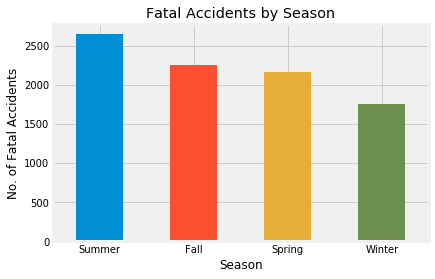

In [36]:
## Fatal accidents by season

pd.value_counts(fatal_crash_df['Season']).plot.bar()
plt.xlabel('Season')
plt.ylabel('No. of Fatal Accidents')
plt.xticks(rotation=0)
plt.title("Fatal Accidents by Season")

Text(0.5,1,'Total Accidents by Season')

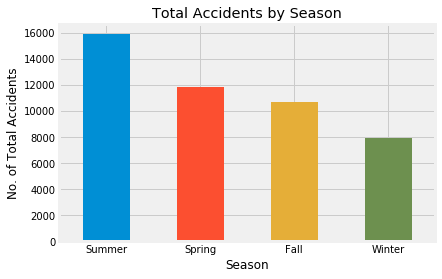

In [37]:
## All accidents by season

pd.value_counts(real_df['Season']).plot.bar()
plt.xlabel('Season')
plt.ylabel('No. of Total Accidents')
plt.xticks(rotation=0)
plt.title("Total Accidents by Season")

(array([0, 1]), <a list of 2 Text xticklabel objects>)

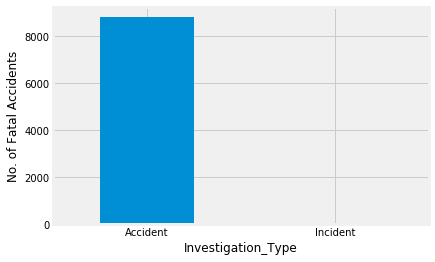

In [38]:
## Fatal accidents by investigation type

pd.value_counts(fatal_crash_df['Investigation_Type']).plot.bar()
plt.xlabel('Investigation_Type')
plt.ylabel('No. of Fatal Accidents')
plt.xticks(rotation=0)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

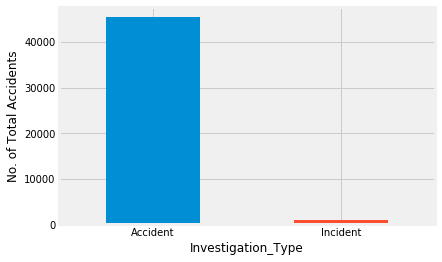

In [39]:
## All accidents by investigation type

pd.value_counts(real_df['Investigation_Type']).plot.bar()
plt.xlabel('Investigation_Type')
plt.ylabel('No. of Total Accidents')
plt.xticks(rotation=0)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

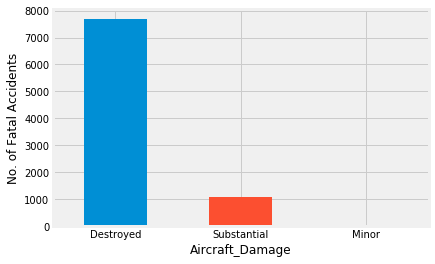

In [40]:
## Fatal accidents by aircraft damage

pd.value_counts(fatal_crash_df['Aircraft_Damage']).plot.bar()
plt.xlabel('Aircraft_Damage')
plt.ylabel('No. of Fatal Accidents')
plt.xticks(rotation=0)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

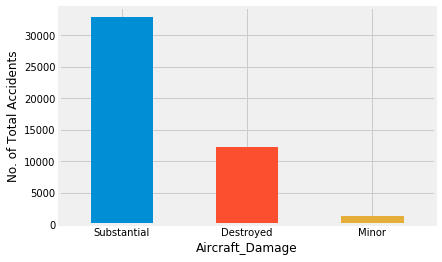

In [41]:
## All accidents by aircraft damage

pd.value_counts(real_df['Aircraft_Damage']).plot.bar()
plt.xlabel('Aircraft_Damage')
plt.ylabel('No. of Total Accidents')
plt.xticks(rotation=0)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

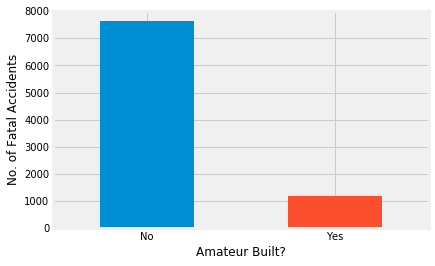

In [42]:
## Fatal accidents by amatuer built

pd.value_counts(fatal_crash_df['Amateur_Built']).plot.bar()
plt.xlabel('Amateur Built?')
plt.ylabel('No. of Fatal Accidents')
plt.xticks(rotation=0)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

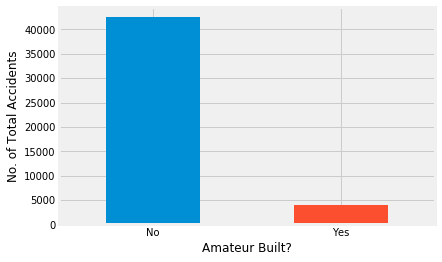

In [43]:
## All accidents by amatuer built

pd.value_counts(real_df['Amateur_Built']).plot.bar()
plt.xlabel('Amateur Built?')
plt.ylabel('No. of Total Accidents')
plt.xticks(rotation=0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

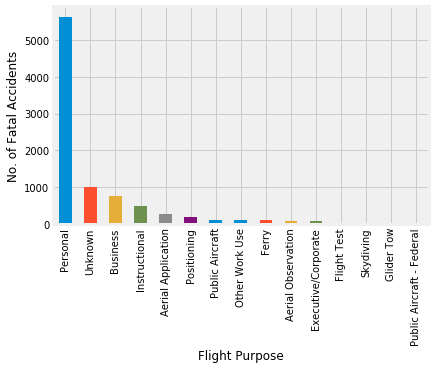

In [44]:
## Fatal accidents by Flight Purpose

pd.value_counts(fatal_crash_df['Flight_Purpose']).plot.bar()
plt.xlabel('Flight Purpose')
plt.ylabel('No. of Fatal Accidents')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text xticklabel objects>)

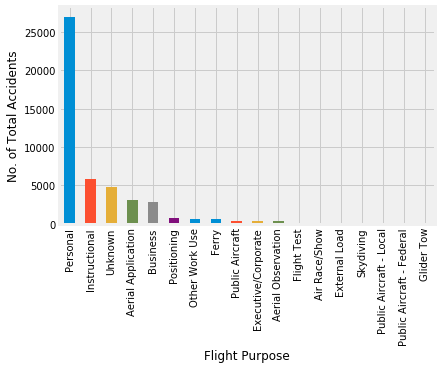

In [45]:
## All accidents by Flight Purpose

pd.value_counts(real_df['Flight_Purpose']).plot.bar()
plt.xlabel('Flight Purpose')
plt.ylabel('No. of Total Accidents')
plt.xticks(rotation=90)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

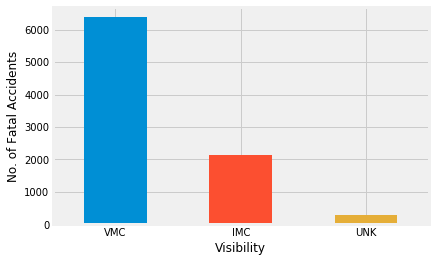

In [46]:
## Fatal accidents by Weather condition

pd.value_counts(fatal_crash_df['Weather_Condition']).plot.bar()
plt.xlabel('Visibility')
plt.ylabel('No. of Fatal Accidents')
plt.xticks(rotation=0)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

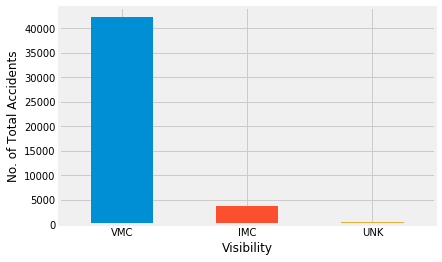

In [47]:
## All accidents by Weather condition

pd.value_counts(real_df['Weather_Condition']).plot.bar()
plt.xlabel('Visibility')
plt.ylabel('No. of Total Accidents')
plt.xticks(rotation=0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

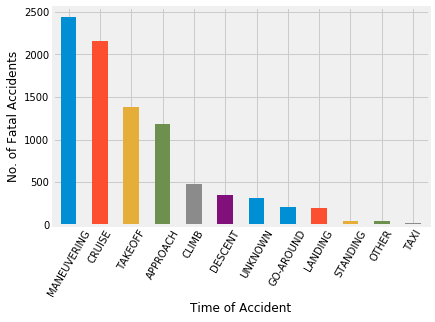

In [48]:
## Fatal accidents by time of accident

pd.value_counts(fatal_crash_df['Broad_Phase_of_Flight']).plot.bar()
plt.xlabel('Time of Accident')
plt.ylabel('No. of Fatal Accidents')
plt.xticks(rotation=60)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

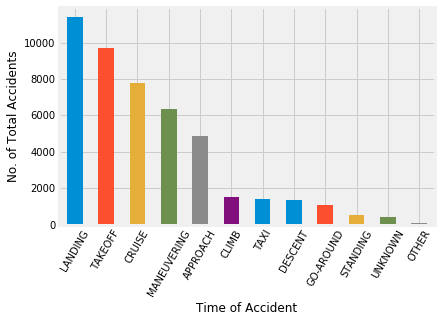

In [49]:
## Alll accidents by time of accident

pd.value_counts(real_df['Broad_Phase_of_Flight']).plot.bar()
plt.xlabel('Time of Accident')
plt.ylabel('No. of Total Accidents')
plt.xticks(rotation=60)

In [50]:
real_df.Flight_Purpose.unique()

array(['Personal', 'Instructional', 'External Load', 'Public Aircraft',
       'Flight Test', 'Skydiving', 'Aerial Application', 'Ferry',
       'Other Work Use', 'Air Race/Show', 'Business',
       'Public Aircraft - Local', 'Positioning', 'Aerial Observation',
       'Executive/Corporate', 'Unknown', 'Glider Tow',
       'Public Aircraft - Federal'], dtype=object)

In [51]:
## keep personal, instructional, business, unknown, aerial application

real_df.Flight_Purpose.replace('External Load', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Public Aircraft', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Flight Test', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Skydiving', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Ferry', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Other Work Use', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Air Race/Show', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Public Aircraft - Local', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Positioning', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Aerial Observation', 'Aerial Application', inplace=True)
real_df.Flight_Purpose.replace('Executive/Corporate', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Glider Tow', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Public Aircraft - Federal', 'Business', inplace=True)

In [52]:
real_df.Flight_Purpose.unique()

array(['Personal', 'Instructional', 'Business', 'Aerial Application',
       'Unknown'], dtype=object)

In [53]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46435 entries, 16185 to 81898
Data columns (total 22 columns):
Event_Id                  46435 non-null object
Investigation_Type        46435 non-null object
Event_Date                46435 non-null datetime64[ns]
Country                   46435 non-null object
Injury_Severity           46435 non-null object
Aircraft_Damage           46435 non-null object
Amateur_Built             46435 non-null object
Number_Engines            46435 non-null float64
Engine_Type               46435 non-null object
Flight_Purpose            46435 non-null object
Total_Fatal_Injuries      46435 non-null float64
Total_Serious_Injuries    46435 non-null float64
Total_Minor_Injuries      46435 non-null float64
Total_Uninjured           46435 non-null float64
Weather_Condition         46435 non-null object
Broad_Phase_of_Flight     46435 non-null object
City                      46435 non-null object
State                     46435 non-null object
Total_Pass

In [54]:
real_df.head()

,Event_Id,Investigation_Type,Event_Date,Country,Injury_Severity,Aircraft_Damage,Amateur_Built,Number_Engines,Engine_Type,Flight_Purpose,...,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,City,State,Total_Passengers,Was_Fatal,Month,Season
16185,20081126X30503,Accident,2008-11-25,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,...,1.0,0.0,VMC,DESCENT,Monterey,CA,2.0,Non-fatal,11,Fall
16254,20081112X43029,Accident,2008-11-08,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Instructional,...,0.0,2.0,VMC,TAKEOFF,Nacogdoches,TX,2.0,Non-fatal,11,Fall
16315,20081024X13647,Accident,2008-10-24,United States,Non-Fatal,Destroyed,Yes,1.0,Reciprocating,Personal,...,0.0,0.0,VMC,GO-AROUND,Breckenridge,TX,2.0,Non-fatal,10,Fall
16337,20081020X12359,Accident,2008-10-19,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,...,0.0,1.0,VMC,APPROACH,Angleton,TX,1.0,Non-fatal,10,Fall
16369,20081012X91435,Accident,2008-10-10,United States,Non-Fatal,Substantial,No,1.0,Turbo Shaft,Business,...,0.0,0.0,VMC,MANEUVERING,Cougar,WA,1.0,Non-fatal,10,Fall


In [55]:
# dummy_damage = pd.get_dummies(real_df['Aircraft_Damage'], prefix='Damage')

# dummy_damage.head()

In [56]:
# real_df = real_df.join(dummy_damage.ix[:, ['Damage_Minor','Damage_Substantial'])

# real_df['intercept'] = 1.0
                                       
# real_df.head()

In [57]:
df_damage = real_df.copy(deep=True)

In [58]:
X=patsy.dmatrix('Aircraft_Damage',data=df_damage,return_type='dataframe')
X.head()

,Intercept,Aircraft_Damage[T.Minor],Aircraft_Damage[T.Substantial]
16185,1.0,0.0,1.0
16254,1.0,0.0,1.0
16315,1.0,0.0,0.0
16337,1.0,0.0,1.0
16369,1.0,0.0,1.0


In [59]:
real_df = real_df.join(X)

In [60]:
real_df['Minor_Damage'] = real_df['Aircraft_Damage[T.Minor]']
real_df['Substantial_Damage'] = real_df['Aircraft_Damage[T.Substantial]']

real_df = real_df.drop(['Aircraft_Damage[T.Minor]','Aircraft_Damage[T.Substantial]','Intercept'],1)

real_df

,Event_Id,Investigation_Type,Event_Date,Country,Injury_Severity,Aircraft_Damage,Amateur_Built,Number_Engines,Engine_Type,Flight_Purpose,...,Weather_Condition,Broad_Phase_of_Flight,City,State,Total_Passengers,Was_Fatal,Month,Season,Minor_Damage,Substantial_Damage
16185,20081126X30503,Accident,2008-11-25,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,...,VMC,DESCENT,Monterey,CA,2.0,Non-fatal,11,Fall,0.0,1.0
16254,20081112X43029,Accident,2008-11-08,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Instructional,...,VMC,TAKEOFF,Nacogdoches,TX,2.0,Non-fatal,11,Fall,0.0,1.0
16315,20081024X13647,Accident,2008-10-24,United States,Non-Fatal,Destroyed,Yes,1.0,Reciprocating,Personal,...,VMC,GO-AROUND,Breckenridge,TX,2.0,Non-fatal,10,Fall,0.0,0.0
16337,20081020X12359,Accident,2008-10-19,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,...,VMC,APPROACH,Angleton,TX,1.0,Non-fatal,10,Fall,0.0,1.0
16369,20081012X91435,Accident,2008-10-10,United States,Non-Fatal,Substantial,No,1.0,Turbo Shaft,Business,...,VMC,MANEUVERING,Cougar,WA,1.0,Non-fatal,10,Fall,0.0,1.0
16370,20081011X02304,Accident,2008-10-10,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,...,VMC,GO-AROUND,Placerville,CA,2.0,Non-fatal,10,Fall,0.0,1.0
16395,20081006X90954,Accident,2008-10-05,United States,Fatal(1),Substantial,Yes,1.0,Reciprocating,Personal,...,VMC,MANEUVERING,Sandy Valley,NV,1.0,Fatal,10,Fall,0.0,1.0
16412,20081002X13229,Accident,2008-10-01,United States,Non-Fatal,Substantial,No,1.0,Turbo Shaft,Business,...,VMC,LANDING,Blaine,WA,2.0,Non-fatal,10,Fall,0.0,1.0
16418,20081006X60439,Accident,2008-09-30,United States,Non-Fatal,Substantial,Yes,1.0,Reciprocating,Personal,...,VMC,TAXI,Idaho Falls,ID,2.0,Non-fatal,9,Fall,0.0,1.0
16438,20081004X12025,Accident,2008-09-27,United States,Non-Fatal,Substantial,No,1.0,Turbo Shaft,Personal,...,VMC,MANEUVERING,Jelm,WY,1.0,Non-fatal,9,Fall,0.0,1.0


In [61]:
real_df.head()

,Event_Id,Investigation_Type,Event_Date,Country,Injury_Severity,Aircraft_Damage,Amateur_Built,Number_Engines,Engine_Type,Flight_Purpose,...,Weather_Condition,Broad_Phase_of_Flight,City,State,Total_Passengers,Was_Fatal,Month,Season,Minor_Damage,Substantial_Damage
16185,20081126X30503,Accident,2008-11-25,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,...,VMC,DESCENT,Monterey,CA,2.0,Non-fatal,11,Fall,0.0,1.0
16254,20081112X43029,Accident,2008-11-08,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Instructional,...,VMC,TAKEOFF,Nacogdoches,TX,2.0,Non-fatal,11,Fall,0.0,1.0
16315,20081024X13647,Accident,2008-10-24,United States,Non-Fatal,Destroyed,Yes,1.0,Reciprocating,Personal,...,VMC,GO-AROUND,Breckenridge,TX,2.0,Non-fatal,10,Fall,0.0,0.0
16337,20081020X12359,Accident,2008-10-19,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,...,VMC,APPROACH,Angleton,TX,1.0,Non-fatal,10,Fall,0.0,1.0
16369,20081012X91435,Accident,2008-10-10,United States,Non-Fatal,Substantial,No,1.0,Turbo Shaft,Business,...,VMC,MANEUVERING,Cougar,WA,1.0,Non-fatal,10,Fall,0.0,1.0


In [62]:
df_amateur = real_df.copy(deep=True)

In [63]:
X=patsy.dmatrix('Amateur_Built',data=df_amateur,return_type='dataframe')
X.head()

,Intercept,Amateur_Built[T.Yes]
16185,1.0,0.0
16254,1.0,0.0
16315,1.0,1.0
16337,1.0,0.0
16369,1.0,0.0


In [64]:
real_df = real_df.join(X)

In [65]:
real_df['Amateur_Built_Yes'] = real_df['Amateur_Built[T.Yes]']

real_df = real_df.drop(['Amateur_Built[T.Yes]','Intercept'],1)

real_df

,Event_Id,Investigation_Type,Event_Date,Country,Injury_Severity,Aircraft_Damage,Amateur_Built,Number_Engines,Engine_Type,Flight_Purpose,...,Broad_Phase_of_Flight,City,State,Total_Passengers,Was_Fatal,Month,Season,Minor_Damage,Substantial_Damage,Amateur_Built_Yes
16185,20081126X30503,Accident,2008-11-25,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,...,DESCENT,Monterey,CA,2.0,Non-fatal,11,Fall,0.0,1.0,0.0
16254,20081112X43029,Accident,2008-11-08,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Instructional,...,TAKEOFF,Nacogdoches,TX,2.0,Non-fatal,11,Fall,0.0,1.0,0.0
16315,20081024X13647,Accident,2008-10-24,United States,Non-Fatal,Destroyed,Yes,1.0,Reciprocating,Personal,...,GO-AROUND,Breckenridge,TX,2.0,Non-fatal,10,Fall,0.0,0.0,1.0
16337,20081020X12359,Accident,2008-10-19,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,...,APPROACH,Angleton,TX,1.0,Non-fatal,10,Fall,0.0,1.0,0.0
16369,20081012X91435,Accident,2008-10-10,United States,Non-Fatal,Substantial,No,1.0,Turbo Shaft,Business,...,MANEUVERING,Cougar,WA,1.0,Non-fatal,10,Fall,0.0,1.0,0.0
16370,20081011X02304,Accident,2008-10-10,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,...,GO-AROUND,Placerville,CA,2.0,Non-fatal,10,Fall,0.0,1.0,0.0
16395,20081006X90954,Accident,2008-10-05,United States,Fatal(1),Substantial,Yes,1.0,Reciprocating,Personal,...,MANEUVERING,Sandy Valley,NV,1.0,Fatal,10,Fall,0.0,1.0,1.0
16412,20081002X13229,Accident,2008-10-01,United States,Non-Fatal,Substantial,No,1.0,Turbo Shaft,Business,...,LANDING,Blaine,WA,2.0,Non-fatal,10,Fall,0.0,1.0,0.0
16418,20081006X60439,Accident,2008-09-30,United States,Non-Fatal,Substantial,Yes,1.0,Reciprocating,Personal,...,TAXI,Idaho Falls,ID,2.0,Non-fatal,9,Fall,0.0,1.0,1.0
16438,20081004X12025,Accident,2008-09-27,United States,Non-Fatal,Substantial,No,1.0,Turbo Shaft,Personal,...,MANEUVERING,Jelm,WY,1.0,Non-fatal,9,Fall,0.0,1.0,0.0


In [66]:
df_flight_purpose = real_df.copy(deep=True)

In [67]:
X=patsy.dmatrix('Flight_Purpose',data=df_flight_purpose,return_type='dataframe')
X.head()

,Intercept,Flight_Purpose[T.Business],Flight_Purpose[T.Instructional],Flight_Purpose[T.Personal],Flight_Purpose[T.Unknown]
16185,1.0,0.0,0.0,1.0,0.0
16254,1.0,0.0,1.0,0.0,0.0
16315,1.0,0.0,0.0,1.0,0.0
16337,1.0,0.0,0.0,1.0,0.0
16369,1.0,1.0,0.0,0.0,0.0


In [68]:
real_df = real_df.join(X)

In [69]:
real_df['Purpose_Personal'] = real_df['Flight_Purpose[T.Personal]']
real_df['Purpose_Instructional'] = real_df['Flight_Purpose[T.Instructional]']
real_df['Purpose_Unknown'] = real_df['Flight_Purpose[T.Unknown]']
real_df['Purpose_Business'] = real_df['Flight_Purpose[T.Business]']


real_df = real_df.drop(['Flight_Purpose[T.Personal]','Flight_Purpose[T.Instructional]',
                        'Flight_Purpose[T.Unknown]','Flight_Purpose[T.Business]','Intercept'],1)

real_df

,Event_Id,Investigation_Type,Event_Date,Country,Injury_Severity,Aircraft_Damage,Amateur_Built,Number_Engines,Engine_Type,Flight_Purpose,...,Was_Fatal,Month,Season,Minor_Damage,Substantial_Damage,Amateur_Built_Yes,Purpose_Personal,Purpose_Instructional,Purpose_Unknown,Purpose_Business
16185,20081126X30503,Accident,2008-11-25,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,...,Non-fatal,11,Fall,0.0,1.0,0.0,1.0,0.0,0.0,0.0
16254,20081112X43029,Accident,2008-11-08,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Instructional,...,Non-fatal,11,Fall,0.0,1.0,0.0,0.0,1.0,0.0,0.0
16315,20081024X13647,Accident,2008-10-24,United States,Non-Fatal,Destroyed,Yes,1.0,Reciprocating,Personal,...,Non-fatal,10,Fall,0.0,0.0,1.0,1.0,0.0,0.0,0.0
16337,20081020X12359,Accident,2008-10-19,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,...,Non-fatal,10,Fall,0.0,1.0,0.0,1.0,0.0,0.0,0.0
16369,20081012X91435,Accident,2008-10-10,United States,Non-Fatal,Substantial,No,1.0,Turbo Shaft,Business,...,Non-fatal,10,Fall,0.0,1.0,0.0,0.0,0.0,0.0,1.0
16370,20081011X02304,Accident,2008-10-10,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,...,Non-fatal,10,Fall,0.0,1.0,0.0,1.0,0.0,0.0,0.0
16395,20081006X90954,Accident,2008-10-05,United States,Fatal(1),Substantial,Yes,1.0,Reciprocating,Personal,...,Fatal,10,Fall,0.0,1.0,1.0,1.0,0.0,0.0,0.0
16412,20081002X13229,Accident,2008-10-01,United States,Non-Fatal,Substantial,No,1.0,Turbo Shaft,Business,...,Non-fatal,10,Fall,0.0,1.0,0.0,0.0,0.0,0.0,1.0
16418,20081006X60439,Accident,2008-09-30,United States,Non-Fatal,Substantial,Yes,1.0,Reciprocating,Personal,...,Non-fatal,9,Fall,0.0,1.0,1.0,1.0,0.0,0.0,0.0
16438,20081004X12025,Accident,2008-09-27,United States,Non-Fatal,Substantial,No,1.0,Turbo Shaft,Personal,...,Non-fatal,9,Fall,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [70]:
## CREATE DUMMY VARIABLES FOR WEATHER CONDITION, BROAD PHASE OF FLIGHT, SEASON, WAS_FATAL (DOES THIS NEED TO BE BINARY 0/1)???

In [71]:
## USE THIS https://medium.com/@rathi.ankit/data-science-pipeline-in-python-255150adb98f

In [72]:
df_weather = real_df.copy(deep=True)

In [73]:
X=patsy.dmatrix('Weather_Condition',data=df_weather,return_type='dataframe')
X.head()

,Intercept,Weather_Condition[T.UNK],Weather_Condition[T.VMC]
16185,1.0,0.0,1.0
16254,1.0,0.0,1.0
16315,1.0,0.0,1.0
16337,1.0,0.0,1.0
16369,1.0,0.0,1.0


In [74]:
real_df = real_df.join(X)

In [75]:
real_df['Weather_Unknown'] = real_df['Weather_Condition[T.UNK]']
real_df['Weather_VMC'] = real_df['Weather_Condition[T.VMC]']


real_df = real_df.drop(['Weather_Condition[T.UNK]','Weather_Condition[T.VMC]','Intercept'],1)

real_df

,Event_Id,Investigation_Type,Event_Date,Country,Injury_Severity,Aircraft_Damage,Amateur_Built,Number_Engines,Engine_Type,Flight_Purpose,...,Season,Minor_Damage,Substantial_Damage,Amateur_Built_Yes,Purpose_Personal,Purpose_Instructional,Purpose_Unknown,Purpose_Business,Weather_Unknown,Weather_VMC
16185,20081126X30503,Accident,2008-11-25,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,...,Fall,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
16254,20081112X43029,Accident,2008-11-08,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Instructional,...,Fall,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
16315,20081024X13647,Accident,2008-10-24,United States,Non-Fatal,Destroyed,Yes,1.0,Reciprocating,Personal,...,Fall,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
16337,20081020X12359,Accident,2008-10-19,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,...,Fall,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
16369,20081012X91435,Accident,2008-10-10,United States,Non-Fatal,Substantial,No,1.0,Turbo Shaft,Business,...,Fall,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
16370,20081011X02304,Accident,2008-10-10,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,...,Fall,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
16395,20081006X90954,Accident,2008-10-05,United States,Fatal(1),Substantial,Yes,1.0,Reciprocating,Personal,...,Fall,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
16412,20081002X13229,Accident,2008-10-01,United States,Non-Fatal,Substantial,No,1.0,Turbo Shaft,Business,...,Fall,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
16418,20081006X60439,Accident,2008-09-30,United States,Non-Fatal,Substantial,Yes,1.0,Reciprocating,Personal,...,Fall,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
16438,20081004X12025,Accident,2008-09-27,United States,Non-Fatal,Substantial,No,1.0,Turbo Shaft,Personal,...,Fall,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [76]:
df_phase_of_flight = real_df.copy(deep=True)

In [77]:
X=patsy.dmatrix('Broad_Phase_of_Flight',data=df_phase_of_flight,return_type='dataframe')
X.head()

,Intercept,Broad_Phase_of_Flight[T.CLIMB],Broad_Phase_of_Flight[T.CRUISE],Broad_Phase_of_Flight[T.DESCENT],Broad_Phase_of_Flight[T.GO-AROUND],Broad_Phase_of_Flight[T.LANDING],Broad_Phase_of_Flight[T.MANEUVERING],Broad_Phase_of_Flight[T.OTHER],Broad_Phase_of_Flight[T.STANDING],Broad_Phase_of_Flight[T.TAKEOFF],Broad_Phase_of_Flight[T.TAXI],Broad_Phase_of_Flight[T.UNKNOWN]
16185,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16254,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16315,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16337,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16369,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [78]:
real_df = real_df.join(X)

In [79]:
real_df['Phase_Climb'] = real_df['Broad_Phase_of_Flight[T.CLIMB]']
real_df['Phase_Cruise'] = real_df['Broad_Phase_of_Flight[T.CRUISE]']
real_df['Phase_Descent'] = real_df['Broad_Phase_of_Flight[T.DESCENT]']
real_df['Phase_GoAround'] = real_df['Broad_Phase_of_Flight[T.GO-AROUND]']
real_df['Phase_Landing'] = real_df['Broad_Phase_of_Flight[T.LANDING]']
real_df['Phase_Maneuvering'] = real_df['Broad_Phase_of_Flight[T.MANEUVERING]']
real_df['Phase_Other'] = real_df['Broad_Phase_of_Flight[T.OTHER]']
real_df['Phase_Standing'] = real_df['Broad_Phase_of_Flight[T.STANDING]']
real_df['Phase_Takeoff'] = real_df['Broad_Phase_of_Flight[T.TAKEOFF]']
real_df['Phase_Taxi'] = real_df['Broad_Phase_of_Flight[T.TAXI]']
real_df['Phase_Unknown'] = real_df['Broad_Phase_of_Flight[T.UNKNOWN]']

real_df = real_df.drop(['Broad_Phase_of_Flight[T.CLIMB]','Broad_Phase_of_Flight[T.CRUISE]','Broad_Phase_of_Flight[T.DESCENT]',
                        'Broad_Phase_of_Flight[T.GO-AROUND]','Broad_Phase_of_Flight[T.LANDING]',
                        'Broad_Phase_of_Flight[T.MANEUVERING]','Broad_Phase_of_Flight[T.OTHER]',
                        'Broad_Phase_of_Flight[T.STANDING]','Broad_Phase_of_Flight[T.TAKEOFF]',
                        'Broad_Phase_of_Flight[T.TAXI]','Broad_Phase_of_Flight[T.UNKNOWN]','Intercept'],1)

real_df

,Event_Id,Investigation_Type,Event_Date,Country,Injury_Severity,Aircraft_Damage,Amateur_Built,Number_Engines,Engine_Type,Flight_Purpose,...,Phase_Cruise,Phase_Descent,Phase_GoAround,Phase_Landing,Phase_Maneuvering,Phase_Other,Phase_Standing,Phase_Takeoff,Phase_Taxi,Phase_Unknown
16185,20081126X30503,Accident,2008-11-25,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16254,20081112X43029,Accident,2008-11-08,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Instructional,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16315,20081024X13647,Accident,2008-10-24,United States,Non-Fatal,Destroyed,Yes,1.0,Reciprocating,Personal,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16337,20081020X12359,Accident,2008-10-19,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16369,20081012X91435,Accident,2008-10-10,United States,Non-Fatal,Substantial,No,1.0,Turbo Shaft,Business,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
16370,20081011X02304,Accident,2008-10-10,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16395,20081006X90954,Accident,2008-10-05,United States,Fatal(1),Substantial,Yes,1.0,Reciprocating,Personal,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
16412,20081002X13229,Accident,2008-10-01,United States,Non-Fatal,Substantial,No,1.0,Turbo Shaft,Business,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
16418,20081006X60439,Accident,2008-09-30,United States,Non-Fatal,Substantial,Yes,1.0,Reciprocating,Personal,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16438,20081004X12025,Accident,2008-09-27,United States,Non-Fatal,Substantial,No,1.0,Turbo Shaft,Personal,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [80]:
df_season = real_df.copy(deep=True)

In [81]:
X=patsy.dmatrix('Season',data=df_season,return_type='dataframe')
X.head()

,Intercept,Season[T.Spring],Season[T.Summer],Season[T.Winter]
16185,1.0,0.0,0.0,0.0
16254,1.0,0.0,0.0,0.0
16315,1.0,0.0,0.0,0.0
16337,1.0,0.0,0.0,0.0
16369,1.0,0.0,0.0,0.0


In [82]:
real_df = real_df.join(X)

In [83]:
### DON'T DROP INTERCEPT ON LAST DUMMIFY

real_df['Spring'] = real_df['Season[T.Spring]']
real_df['Summer'] = real_df['Season[T.Summer]']
real_df['Winter'] = real_df['Season[T.Winter]']

real_df = real_df.drop(['Season[T.Spring]','Season[T.Summer]','Season[T.Winter]'],1)

real_df

,Event_Id,Investigation_Type,Event_Date,Country,Injury_Severity,Aircraft_Damage,Amateur_Built,Number_Engines,Engine_Type,Flight_Purpose,...,Phase_Maneuvering,Phase_Other,Phase_Standing,Phase_Takeoff,Phase_Taxi,Phase_Unknown,Intercept,Spring,Summer,Winter
16185,20081126X30503,Accident,2008-11-25,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16254,20081112X43029,Accident,2008-11-08,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Instructional,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
16315,20081024X13647,Accident,2008-10-24,United States,Non-Fatal,Destroyed,Yes,1.0,Reciprocating,Personal,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16337,20081020X12359,Accident,2008-10-19,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16369,20081012X91435,Accident,2008-10-10,United States,Non-Fatal,Substantial,No,1.0,Turbo Shaft,Business,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16370,20081011X02304,Accident,2008-10-10,United States,Non-Fatal,Substantial,No,1.0,Reciprocating,Personal,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16395,20081006X90954,Accident,2008-10-05,United States,Fatal(1),Substantial,Yes,1.0,Reciprocating,Personal,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16412,20081002X13229,Accident,2008-10-01,United States,Non-Fatal,Substantial,No,1.0,Turbo Shaft,Business,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16418,20081006X60439,Accident,2008-09-30,United States,Non-Fatal,Substantial,Yes,1.0,Reciprocating,Personal,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
16438,20081004X12025,Accident,2008-09-27,United States,Non-Fatal,Substantial,No,1.0,Turbo Shaft,Personal,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [84]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46435 entries, 16185 to 81898
Data columns (total 46 columns):
Event_Id                  46435 non-null object
Investigation_Type        46435 non-null object
Event_Date                46435 non-null datetime64[ns]
Country                   46435 non-null object
Injury_Severity           46435 non-null object
Aircraft_Damage           46435 non-null object
Amateur_Built             46435 non-null object
Number_Engines            46435 non-null float64
Engine_Type               46435 non-null object
Flight_Purpose            46435 non-null object
Total_Fatal_Injuries      46435 non-null float64
Total_Serious_Injuries    46435 non-null float64
Total_Minor_Injuries      46435 non-null float64
Total_Uninjured           46435 non-null float64
Weather_Condition         46435 non-null object
Broad_Phase_of_Flight     46435 non-null object
City                      46435 non-null object
State                     46435 non-null object
Total_Pass

In [85]:
real_df.describe()

,Number_Engines,Total_Fatal_Injuries,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Total_Passengers,Month,Minor_Damage,Substantial_Damage,Amateur_Built_Yes,...,Phase_Maneuvering,Phase_Other,Phase_Standing,Phase_Takeoff,Phase_Taxi,Phase_Unknown,Intercept,Spring,Summer,Winter
count,46435.000000,46435.000000,46435.000000,46435.000000,46435.000000,46435.000000,46435.000000,46435.000000,46435.000000,46435.000000,...,46435.000000,46435.000000,46435.000000,46435.000000,46435.00000,46435.000000,46435.0,46435.000000,46435.000000,46435.000000
mean,1.132271,0.398729,0.193023,0.320793,2.640788,3.553333,6.576677,0.027781,0.707441,0.084570,...,0.136664,0.001874,0.011285,0.208593,0.03058,0.009023,1.0,0.255325,0.342651,0.170755
std,0.407736,2.339938,0.825010,1.391938,16.460601,16.921940,3.048776,0.164346,0.454943,0.278243,...,0.343496,0.043245,0.105629,0.406307,0.17218,0.094563,0.0,0.436048,0.474601,0.376299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.0,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.0,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,7.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.0,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,9.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.0,1.000000,1.000000,0.000000
max,4.000000,230.000000,81.000000,125.000000,507.000000,507.000000,12.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.0,1.000000,1.000000,1.000000


In [86]:
real_df.columns

Index(['Event_Id', 'Investigation_Type', 'Event_Date', 'Country',
       'Injury_Severity', 'Aircraft_Damage', 'Amateur_Built', 'Number_Engines',
       'Engine_Type', 'Flight_Purpose', 'Total_Fatal_Injuries',
       'Total_Serious_Injuries', 'Total_Minor_Injuries', 'Total_Uninjured',
       'Weather_Condition', 'Broad_Phase_of_Flight', 'City', 'State',
       'Total_Passengers', 'Was_Fatal', 'Month', 'Season', 'Minor_Damage',
       'Substantial_Damage', 'Amateur_Built_Yes', 'Purpose_Personal',
       'Purpose_Instructional', 'Purpose_Unknown', 'Purpose_Business',
       'Weather_Unknown', 'Weather_VMC', 'Phase_Climb', 'Phase_Cruise',
       'Phase_Descent', 'Phase_GoAround', 'Phase_Landing', 'Phase_Maneuvering',
       'Phase_Other', 'Phase_Standing', 'Phase_Takeoff', 'Phase_Taxi',
       'Phase_Unknown', 'Intercept', 'Spring', 'Summer', 'Winter'],
      dtype='object')

In [87]:
real_df.Engine_Type.value_counts()

Reciprocating    41962
Turbo Shaft       1681
Turbo Prop        1367
Turbo Fan          653
Unknown            469
Turbo Jet          303
Name: Engine_Type, dtype: int64

In [88]:
target_count = real_df['Was_Fatal'].value_counts()
print(f'Non-Fatal: {target_count[0]}')
print(f'Fatal: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

Non-Fatal: 37626
Fatal: 8809
Proportion: 4.27 : 1
Percentage of Majority Class: 81.03


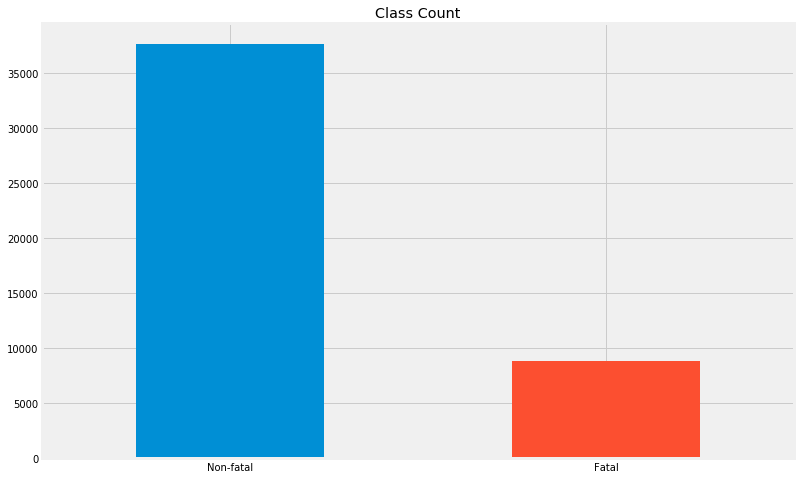

In [89]:
target_count.plot(kind='bar', title='Class Count', rot=0);
plt.gcf().set_size_inches(12,8)

In [90]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

# NEED TO SCALE NUMERICAL DATA

In [91]:
## DUMMIFY ENGINE TYPE AND ADD? ADD REGION FROM PSQL??

y = real_df['Was_Fatal']
X = real_df[['Minor_Damage','Substantial_Damage','Total_Passengers',
       'Amateur_Built_Yes', 'Number_Engines', 'Purpose_Personal',
       'Purpose_Instructional', 'Purpose_Unknown', 'Purpose_Business',
       'Weather_Unknown', 'Weather_VMC', 'Phase_Climb', 'Phase_Cruise',
       'Phase_Descent', 'Phase_GoAround', 'Phase_Landing', 'Phase_Maneuvering',
       'Phase_Other', 'Phase_Standing', 'Phase_Takeoff', 'Phase_Taxi',
       'Phase_Unknown', 'Intercept', 'Spring', 'Summer', 'Winter']]

X_train, X_FINALtest, y_train, y_FINALtest = train_test_split(X, y, test_size=0.3, random_state=4444, stratify=y)

In [92]:
X_train.head()

,Minor_Damage,Substantial_Damage,Total_Passengers,Amateur_Built_Yes,Number_Engines,Purpose_Personal,Purpose_Instructional,Purpose_Unknown,Purpose_Business,Weather_Unknown,...,Phase_Maneuvering,Phase_Other,Phase_Standing,Phase_Takeoff,Phase_Taxi,Phase_Unknown,Intercept,Spring,Summer,Winter
45840,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
42837,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
53148,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
50617,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
61522,0.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [93]:
ssX = StandardScaler()
X_train_scalable = X_train.filter(['Number_Engines','Total_Passengers'], axis=1)
X_train_scaled_columns = pd.DataFrame(ssX.fit_transform(X_train_scalable), columns = ['Number_Engines_Scaled','Total_Passengers_Scaled'])

X_train.reset_index(inplace=True)
X_train = X_train.join(X_train_scaled_columns)
X_train = X_train.drop(['Number_Engines','Total_Passengers'],1)

X_train = X_train.set_index('index')

X_test_scalable = X_FINALtest.filter(['Number_Engines','Total_Passengers'], axis=1)
X_test_scaled_columns = pd.DataFrame(ssX.transform(X_test_scalable), columns = ['Number_Engines_Scaled','Total_Passengers_Scaled'])

X_FINALtest.reset_index(inplace=True)
X_FINALtest = X_FINALtest.join(X_test_scaled_columns)
X_FINALtest = X_FINALtest.drop(['Number_Engines','Total_Passengers'],1)

X_FINALtest = X_FINALtest.set_index('index')

In [94]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32504 entries, 45840 to 43366
Data columns (total 26 columns):
Minor_Damage               32504 non-null float64
Substantial_Damage         32504 non-null float64
Amateur_Built_Yes          32504 non-null float64
Purpose_Personal           32504 non-null float64
Purpose_Instructional      32504 non-null float64
Purpose_Unknown            32504 non-null float64
Purpose_Business           32504 non-null float64
Weather_Unknown            32504 non-null float64
Weather_VMC                32504 non-null float64
Phase_Climb                32504 non-null float64
Phase_Cruise               32504 non-null float64
Phase_Descent              32504 non-null float64
Phase_GoAround             32504 non-null float64
Phase_Landing              32504 non-null float64
Phase_Maneuvering          32504 non-null float64
Phase_Other                32504 non-null float64
Phase_Standing             32504 non-null float64
Phase_Takeoff              32504 non-

In [95]:
X_train.head()

,Minor_Damage,Substantial_Damage,Amateur_Built_Yes,Purpose_Personal,Purpose_Instructional,Purpose_Unknown,Purpose_Business,Weather_Unknown,Weather_VMC,Phase_Climb,...,Phase_Standing,Phase_Takeoff,Phase_Taxi,Phase_Unknown,Intercept,Spring,Summer,Winter,Number_Engines_Scaled,Total_Passengers_Scaled
index,,,,,,,,,,,,,,,,,,,,,
45840,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.325405,-0.094129
42837,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.325405,-0.150841
53148,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.325405,-0.094129
50617,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.325405,-0.094129
61522,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.121832,-0.094129


In [96]:
X_train.columns

Index(['Minor_Damage', 'Substantial_Damage', 'Amateur_Built_Yes',
       'Purpose_Personal', 'Purpose_Instructional', 'Purpose_Unknown',
       'Purpose_Business', 'Weather_Unknown', 'Weather_VMC', 'Phase_Climb',
       'Phase_Cruise', 'Phase_Descent', 'Phase_GoAround', 'Phase_Landing',
       'Phase_Maneuvering', 'Phase_Other', 'Phase_Standing', 'Phase_Takeoff',
       'Phase_Taxi', 'Phase_Unknown', 'Intercept', 'Spring', 'Summer',
       'Winter', 'Number_Engines_Scaled', 'Total_Passengers_Scaled'],
      dtype='object')

In [97]:
X_FINALtest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13931 entries, 66498 to 78308
Data columns (total 26 columns):
Minor_Damage               13931 non-null float64
Substantial_Damage         13931 non-null float64
Amateur_Built_Yes          13931 non-null float64
Purpose_Personal           13931 non-null float64
Purpose_Instructional      13931 non-null float64
Purpose_Unknown            13931 non-null float64
Purpose_Business           13931 non-null float64
Weather_Unknown            13931 non-null float64
Weather_VMC                13931 non-null float64
Phase_Climb                13931 non-null float64
Phase_Cruise               13931 non-null float64
Phase_Descent              13931 non-null float64
Phase_GoAround             13931 non-null float64
Phase_Landing              13931 non-null float64
Phase_Maneuvering          13931 non-null float64
Phase_Other                13931 non-null float64
Phase_Standing             13931 non-null float64
Phase_Takeoff              13931 non-

In [98]:
## THIS IS JUST USING DEFAULTS FOR EACH TYPE -- NEED TO TUNE HYPERPARAMETERS

X_temptrain, X_temptest, y_temptrain, y_temptest = train_test_split(X_train, y_train, test_size=0.3, random_state=4444)

models = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), SVC(probability= True), DecisionTreeClassifier(), RandomForestClassifier()]
names = ['LR', 'KNN', 'NB', 'SVC', 'Decision Tree', 'Random Forest']

for i in range(len(models)):    
    models[i].fit(X_temptrain, y_temptrain)
    y_predict = models[i].predict(X_temptest)
    accuracy = np.round(accuracy_score(y_temptest, y_predict), 4)
    precision = np.round(precision_score(y_temptest, y_predict, pos_label = 'Fatal'), 4)
    recall = np.round(recall_score(y_temptest, y_predict, pos_label = 'Fatal'), 4)
    f1 = np.round(f1_score(y_temptest, y_predict, pos_label = 'Fatal'), 4)
    print(f'{names[i]} acc: {accuracy} prec: {precision} recall: {recall} f1-score: {f1}')
    print('')

LR acc: 0.8988 prec: 0.7221 recall: 0.7531 f1-score: 0.7373

KNN acc: 0.8849 prec: 0.6971 recall: 0.6895 f1-score: 0.6933

NB acc: 0.8441 prec: 0.5591 recall: 0.8211 f1-score: 0.6652

SVC acc: 0.8926 prec: 0.6763 recall: 0.826 f1-score: 0.7437

Decision Tree acc: 0.8818 prec: 0.6828 recall: 0.6966 f1-score: 0.6896

Random Forest acc: 0.8878 prec: 0.7118 recall: 0.6808 f1-score: 0.6959



In [99]:
## THIS IS JUST USING DEFAULTS FOR EACH TYPE -- NEED TO TUNE HYPERPARAMETERS
## NO RESAMPLING

for i in range(len(models)):
    
    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    
    for train_index, test_index in kf.split(X_train):
        
        kX_train = X_train.iloc[train_index]
        kX_test = X_train.iloc[test_index]
        ky_train = y_train.iloc[train_index]
        ky_test = y_train.iloc[test_index]
        
        models[i].fit(kX_train, ky_train)
        y_predict = models[i].predict(kX_test)
        
        accuracy.append(accuracy_score(ky_test, y_predict))
        precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
        recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
        f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    
    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    
    print('Scores with Base Model')
    print(f'{names[i]} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
    print('')

Scores with Base Model
LR accuracy: 0.8963 precision: 0.7202 recall: 0.7419 f1: 0.7307

Scores with Base Model
KNN accuracy: 0.8839 precision: 0.7045 recall: 0.6684 f1: 0.6859

Scores with Base Model
NB accuracy: 0.8413 precision: 0.5563 recall: 0.8103 f1: 0.6596

Scores with Base Model
SVC accuracy: 0.892 precision: 0.6782 recall: 0.8194 f1: 0.7421

Scores with Base Model
Decision Tree accuracy: 0.8821 precision: 0.6875 recall: 0.6945 f1: 0.6909

Scores with Base Model
Random Forest accuracy: 0.8879 precision: 0.7189 recall: 0.6718 f1: 0.6944



In [100]:
from collections import Counter

In [101]:
# Counter(y_train)

# Counter({'Fatal': 6166, 'Non-fatal': 26338})

In [102]:
# ! pip install imblearn

# Done

In [103]:
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=0)
# X_oversampled, y_oversampled = ros.fit_sample(X_train,y_train)

# X_train_resampled = pd.DataFrame(X_oversampled, columns=['Minor_Damage', 'Substantial_Damage', 'Amateur_Built_Yes',
#        'Purpose_Personal', 'Purpose_Instructional', 'Purpose_Unknown',
#        'Purpose_Business', 'Weather_Unknown', 'Weather_VMC', 'Phase_Climb',
#        'Phase_Cruise', 'Phase_Descent', 'Phase_GoAround', 'Phase_Landing',
#        'Phase_Maneuvering', 'Phase_Other', 'Phase_Standing', 'Phase_Takeoff',
#        'Phase_Taxi', 'Phase_Unknown', 'Intercept', 'Spring', 'Summer',
#        'Winter', 'Number_Engines_Scaled', 'Total_Passengers_Scaled'])

# y_train_resampled = pd.Series(y_oversampled)

In [104]:
# Counter(y_train_resampled)

# Counter({'Fatal': 26338, 'Non-fatal': 26338})

In [105]:
## USING RANDOMOVERSAMPLER

# for i in range(len(models)):
    
#     kf = KFold(random_state = 4444)
#     accuracy = []
#     precision = []
#     recall = []
#     f1 = []
    
#     for train_index, test_index in kf.split(X_train_resampled):
        
#         kX_train = X_train_resampled.iloc[train_index]
#         kX_test = X_train_resampled.iloc[test_index]
#         ky_train = y_train_resampled.iloc[train_index]
#         ky_test = y_train_resampled.iloc[test_index]
        
#         models[i].fit(kX_train, ky_train)
#         y_predict = models[i].predict(kX_test)
        
#         accuracy.append(accuracy_score(ky_test, y_predict))
#         precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
#         recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
#         f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    
#     accuracy = np.round(np.mean(accuracy), 4)
#     precision = np.round(np.mean(precision), 4)
#     recall = np.round(np.mean(recall), 4)
#     f1 = np.round(np.mean(f1), 4)
    
#     print('Scores with Random Oversampling')
#     print(f'{names[i]} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
#     print('')

Scores with Random Oversampling
LR accuracy: 0.8487 precision: 0.7727 recall: 0.8695 f1: 0.8044

Scores with Random Oversampling
KNN accuracy: 0.8074 precision: 0.7697 recall: 0.7962 f1: 0.7649

Scores with Random Oversampling
NB accuracy: 0.828 precision: 0.7265 recall: 0.8627 f1: 0.7719

Scores with Random Oversampling
SVC accuracy: 0.8575 precision: 0.791 recall: 0.8609 f1: 0.8138

Scores with Random Oversampling
Decision Tree accuracy: 0.8474 precision: 0.7573 recall: 0.9013 f1: 0.8057

Scores with Random Oversampling
Random Forest accuracy: 0.8475 precision: 0.7619 recall: 0.8974 f1: 0.8068



Scores with Random Oversampling
LR accuracy: 0.8487 precision: 0.7727 recall: 0.8695 f1: 0.8044

Scores with Random Oversampling
KNN accuracy: 0.8074 precision: 0.7697 recall: 0.7962 f1: 0.7649

Scores with Random Oversampling
NB accuracy: 0.828 precision: 0.7265 recall: 0.8627 f1: 0.7719

Scores with Random Oversampling
SVC accuracy: 0.8575 precision: 0.791 recall: 0.8609 f1: 0.8138

Scores with Random Oversampling
Decision Tree accuracy: 0.8474 precision: 0.7573 recall: 0.9013 f1: 0.8057

Scores with Random Oversampling
Random Forest accuracy: 0.8475 precision: 0.7619 recall: 0.8974 f1: 0.8068

In [106]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

X_smoted = pd.DataFrame(X_smoted, columns=['Minor_Damage', 'Substantial_Damage', 'Amateur_Built_Yes',
       'Purpose_Personal', 'Purpose_Instructional', 'Purpose_Unknown',
       'Purpose_Business', 'Weather_Unknown', 'Weather_VMC', 'Phase_Climb',
       'Phase_Cruise', 'Phase_Descent', 'Phase_GoAround', 'Phase_Landing',
       'Phase_Maneuvering', 'Phase_Other', 'Phase_Standing', 'Phase_Takeoff',
       'Phase_Taxi', 'Phase_Unknown', 'Intercept', 'Spring', 'Summer',
       'Winter', 'Number_Engines_Scaled', 'Total_Passengers_Scaled'])

y_smoted = pd.Series(y_smoted)

In [107]:
# Counter(y_smoted)

In [108]:
# USING SMOTE

for i in range(len(models)):
    
    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    
    for train_index, test_index in kf.split(X_smoted):
        
        kX_train = X_smoted.iloc[train_index]
        kX_test = X_smoted.iloc[test_index]
        ky_train = y_smoted.iloc[train_index]
        ky_test = y_smoted.iloc[test_index]
        
        models[i].fit(kX_train, ky_train)
        y_predict = models[i].predict(kX_test)
        
        accuracy.append(accuracy_score(ky_test, y_predict))
        precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
        recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
        f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    
    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    
    print('Scores with SMOTE Oversampling')
    print(f'{names[i]} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
    print('')

Scores with SMOTE Oversampling
LR accuracy: 0.8571 precision: 0.7799 recall: 0.8758 f1: 0.8128

Scores with SMOTE Oversampling
KNN accuracy: 0.8237 precision: 0.7881 recall: 0.8029 f1: 0.7823

Scores with SMOTE Oversampling
NB accuracy: 0.8041 precision: 0.6889 recall: 0.881 f1: 0.7492

Scores with SMOTE Oversampling
SVC accuracy: 0.866 precision: 0.7961 recall: 0.8668 f1: 0.8209

Scores with SMOTE Oversampling
Decision Tree accuracy: 0.8708 precision: 0.7875 recall: 0.8752 f1: 0.8203

Scores with SMOTE Oversampling
Random Forest accuracy: 0.8638 precision: 0.795 recall: 0.8708 f1: 0.8211



Scores with SMOTE Oversampling
LR accuracy: 0.8571 precision: 0.7799 recall: 0.8758 f1: 0.8128

Scores with SMOTE Oversampling
KNN accuracy: 0.8237 precision: 0.7881 recall: 0.8029 f1: 0.7823

Scores with SMOTE Oversampling
NB accuracy: 0.8041 precision: 0.6889 recall: 0.881 f1: 0.7492

Scores with SMOTE Oversampling
SVC accuracy: 0.866 precision: 0.7961 recall: 0.8668 f1: 0.8209

Scores with SMOTE Oversampling
Decision Tree accuracy: 0.8708 precision: 0.7875 recall: 0.8752 f1: 0.8203

Scores with SMOTE Oversampling
Random Forest accuracy: 0.8638 precision: 0.795 recall: 0.8708 f1: 0.8211

In [109]:
# from imblearn.over_sampling import ADASYN
# X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X_train,y_train)

# X_adasyn = pd.DataFrame(X_adasyn, columns=['Minor_Damage', 'Substantial_Damage', 'Amateur_Built_Yes',
#        'Purpose_Personal', 'Purpose_Instructional', 'Purpose_Unknown',
#        'Purpose_Business', 'Weather_Unknown', 'Weather_VMC', 'Phase_Climb',
#        'Phase_Cruise', 'Phase_Descent', 'Phase_GoAround', 'Phase_Landing',
#        'Phase_Maneuvering', 'Phase_Other', 'Phase_Standing', 'Phase_Takeoff',
#        'Phase_Taxi', 'Phase_Unknown', 'Intercept', 'Spring', 'Summer',
#        'Winter', 'Number_Engines_Scaled', 'Total_Passengers_Scaled'])

# y_adasyn = pd.Series(y_adasyn)

In [110]:
# Counter(y_adasyn)

In [111]:
## USING ADASYN

# for i in range(len(models)):
    
#     kf = KFold(random_state = 4444)
#     accuracy = []
#     precision = []
#     recall = []
#     f1 = []
    
#     for train_index, test_index in kf.split(X_adasyn):
        
#         kX_train = X_adasyn.iloc[train_index]
#         kX_test = X_adasyn.iloc[test_index]
#         ky_train = y_adasyn.iloc[train_index]
#         ky_test = y_adasyn.iloc[test_index]
        
#         models[i].fit(kX_train, ky_train)
#         y_predict = models[i].predict(kX_test)
        
#         accuracy.append(accuracy_score(ky_test, y_predict))
#         precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
#         recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
#         f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    
#     accuracy = np.round(np.mean(accuracy), 4)
#     precision = np.round(np.mean(precision), 4)
#     recall = np.round(np.mean(recall), 4)
#     f1 = np.round(np.mean(f1), 4)
    
#     print('Scores with ADASYN Oversampling')
#     print(f'{names[i]} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
#     print('')

Scores with ADASYN Oversampling
LR accuracy: 0.7771 precision: 0.7351 recall: 0.8191 f1: 0.7446

Scores with ADASYN Oversampling
KNN accuracy: 0.7188 precision: 0.7585 recall: 0.6911 f1: 0.6856

Scores with ADASYN Oversampling
NB accuracy: 0.7017 precision: 0.6245 recall: 0.8376 f1: 0.6677

Scores with ADASYN Oversampling
SVC accuracy: 0.7994 precision: 0.7526 recall: 0.8259 f1: 0.7637

Scores with ADASYN Oversampling
Decision Tree accuracy: 0.8247 precision: 0.7595 recall: 0.8423 f1: 0.7816

Scores with ADASYN Oversampling
Random Forest accuracy: 0.8185 precision: 0.7645 recall: 0.8376 f1: 0.7805



Scores with ADASYN Oversampling
LR accuracy: 0.7771 precision: 0.7351 recall: 0.8191 f1: 0.7446

Scores with ADASYN Oversampling
KNN accuracy: 0.7188 precision: 0.7585 recall: 0.6911 f1: 0.6856

Scores with ADASYN Oversampling
NB accuracy: 0.7017 precision: 0.6245 recall: 0.8376 f1: 0.6677

Scores with ADASYN Oversampling
SVC accuracy: 0.7994 precision: 0.7526 recall: 0.8259 f1: 0.7637

Scores with ADASYN Oversampling
Decision Tree accuracy: 0.8247 precision: 0.7595 recall: 0.8423 f1: 0.7816

Scores with ADASYN Oversampling
Random Forest accuracy: 0.8185 precision: 0.7645 recall: 0.8376 f1: 0.7805

# USE SMOTE FOR OVERSAMPLING

In [112]:
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler()
# X_under, y_under = rus.fit_sample(X_train,y_train)

# X_under = pd.DataFrame(X_under, columns=['Minor_Damage', 'Substantial_Damage', 'Amateur_Built_Yes',
#        'Purpose_Personal', 'Purpose_Instructional', 'Purpose_Unknown',
#        'Purpose_Business', 'Weather_Unknown', 'Weather_VMC', 'Phase_Climb',
#        'Phase_Cruise', 'Phase_Descent', 'Phase_GoAround', 'Phase_Landing',
#        'Phase_Maneuvering', 'Phase_Other', 'Phase_Standing', 'Phase_Takeoff',
#        'Phase_Taxi', 'Phase_Unknown', 'Intercept', 'Spring', 'Summer',
#        'Winter', 'Number_Engines_Scaled', 'Total_Passengers_Scaled'])

# y_under = pd.Series(y_under)

In [113]:
# Counter(y_under)

In [114]:
## USING RANDOM UNDERSAMPLING

# for i in range(len(models)):
    
#     kf = KFold(random_state = 4444)
#     accuracy = []
#     precision = []
#     recall = []
#     f1 = []
    
#     for train_index, test_index in kf.split(X_under):
        
#         kX_train = X_under.iloc[train_index]
#         kX_test = X_under.iloc[test_index]
#         ky_train = y_under.iloc[train_index]
#         ky_test = y_under.iloc[test_index]
        
#         models[i].fit(kX_train, ky_train)
#         y_predict = models[i].predict(kX_test)
        
#         accuracy.append(accuracy_score(ky_test, y_predict))
#         precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
#         recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
#         f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    
#     accuracy = np.round(np.mean(accuracy), 4)
#     precision = np.round(np.mean(precision), 4)
#     recall = np.round(np.mean(recall), 4)
#     f1 = np.round(np.mean(f1), 4)
    
#     print('Scores with Random undersampling')
#     print(f'{names[i]} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
#     print('')

/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Scores with Random undersampling
LR accuracy: 0.8411 precision: 0.6287 recall: 0.5711 f1: 0.5974

Scores with Random undersampling
KNN accuracy: 0.6985 precision: 0.5853 recall: 0.5683 f1: 0.57

Scores with Random undersampling
NB accuracy: 0.8072 precision: 0.6066 recall: 0.5491 f1: 0.5733

Scores with Random undersampling
SVC accuracy: 0.8557 precision: 0.6259 recall: 0.5764 f1: 0.5991

Scores with Random undersampling
Decision Tree accuracy: 0.7756 precision: 0.6137 recall: 0.5437 f1: 0.5718

Scores with Random undersampling
Random Forest accuracy: 0.7816 precision: 0.6193 recall: 0.5428 f1: 0.5742



/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Scores with Random undersampling
LR accuracy: 0.8411 precision: 0.6287 recall: 0.5711 f1: 0.5974

Scores with Random undersampling
KNN accuracy: 0.6985 precision: 0.5853 recall: 0.5683 f1: 0.57

Scores with Random undersampling
NB accuracy: 0.8072 precision: 0.6066 recall: 0.5491 f1: 0.5733

Scores with Random undersampling
SVC accuracy: 0.8557 precision: 0.6259 recall: 0.5764 f1: 0.5991

Scores with Random undersampling
Decision Tree accuracy: 0.7756 precision: 0.6137 recall: 0.5437 f1: 0.5718

Scores with Random undersampling
Random Forest accuracy: 0.7816 precision: 0.6193 recall: 0.5428 f1: 0.5742

# PCA & HYPERPARAMETER TUNING PER MODEL TYPE (USE SMOTE)

In [115]:
# real_df.to_csv('airline_crash.csv')

## NEED TO COPY THIS DATABASE ON SSH MYAWS (TERMINAL) FIRST!

### scp /Users/brendenrossin/github/Project_Mcnulty/airline_crash.csv myaws:.

In [116]:
# connection_args = {
#     'host': '18.222.195.175', # Your IP
#     'user': 'ubuntu',    # username
#     'dbname': 'airplane_crash',   # DB that we are connecting to
#     'port': 5432         # port we opened on AWS
# }

# connection = pg.connect(**connection_args)

In [117]:
# query = """
#     CREATE TABLE region(
#       state TEXT,
#       region TEXT);
# """

# pd_sql.read_sql(query, connection)

In [118]:
# query = "COPY region FROM '/home/ubuntu/regions.csv' DELIMITER ',' CSV;"

# pd_sql.read_sql(query, connection)

In [119]:
# query = """
#     CREATE TABLE airline_crash(
#       Event_Id TEXT,
#       Investigation_Type TEXT,
#       Event_Date DATE,
#       Country TEXT,
#       Injury_Severity TEXT,
#       Aircraft_Damage TEXT,
#       Amateur_Built TEXT,
#       Number_Engines INT,
#       Engine_Type TEXT,
#       Flight_Purpose TEXT,
#       Total_Fatal_Injuries INT,
#       Total_Serious_Injuries INT,
#       Total_Minor_Injuries INT,
#       Total_Uninjured INT,
#       Weather_Condition TEXT,
#       Broad_Phase_of_Flight TEXT,
#       City TEXT,
#       State TEXT,
#       Total_Passengers INT,
#       Was_Fatal TEXT,
#       Month INT,
#       Season TEXT
#       );
# """

# pd_sql.read_sql(query, connection)

In [120]:
# query = "COPY airline_crash FROM '/home/ubuntu/airline_crash.csv' DELIMITER ',' CSV;"

# pd_sql.read_sql(query, connection)